# Resources and credit:
- SSDD data download: https://github.com/TianwenZhang0825/LS-SSDD-v1.0-OPEN
- Convering xml to csv: https://github.com/asetkn/Tutorial-Image-and-Multiple-Bounding-Boxes-Augmentation-for-Deep-Learning-in-4-Steps/blob/master/Tutorial-Image-and-Multiple-Bounding-Boxes-Augmentation-for-Deep-Learning-in-4-Steps.ipynb
- Detectron2 docs: https://detectron2.readthedocs.io/en/latest/index.html

#Preprocessing

## Imports

In [ ]:
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
import imageio
import pandas as pd
import numpy as np
import re
import os
import glob
import xml.etree.ElementTree as ET
import shutil
import pickle
ia.seed(1)
%matplotlib inline

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Global paths (Using SSDD default folder structure)
root = '/content/drive/MyDrive/SSDD/'
xml_path = '/content/drive/MyDrive/SSDD/Annotations_sub/'
jpg_path = '/content/drive/MyDrive/SSDD/JPEGImages_sub/'
dest = '/content/drive/MyDrive/SSDD/datasets/'
imagesets = '/content/drive/MyDrive/SSDD/ImageSets/Main/'

## Creating train, test, test_inshore, test_offshore folders
*Only done once after downloading LS-SSDD-v1.0 source data for the first time*

In [ ]:
import shutil
os.makedir(dest)
os.makedir(dest + "train/")
os.makedir(dest + "test/")
os.makedir(dest + "test_offshore/")
os.makedir(dest + "test_inshore/")

In [ ]:
# Read a comma-separated values (csv) file into DataFrame.
test = pd.read_csv(imagesets + 'test.txt', header = None, names = ['file'])
train = pd.read_csv(imagesets + 'train.txt', header = None, names = ['file'])
test_offshore = pd.read_csv(imagesets + 'test_offshore.txt', header = None, names = ['file'])
test_inshore = pd.read_csv(imagesets + 'test_inshore.txt', header = None, names = ['file'])

In [ ]:
print(type(test))
print(test.shape)
test.head()

<class 'pandas.core.frame.DataFrame'>
(3000, 1)


,file
0,11_10_1
1,11_10_10
2,11_10_11
3,11_10_12
4,11_10_13


In [ ]:
print(test['file'][3])

11_10_12


In [ ]:
print(test['file'])

0        11_10_1
1       11_10_10
2       11_10_11
3       11_10_12
4       11_10_13
          ...   
2995      15_9_5
2996      15_9_6
2997      15_9_7
2998      15_9_8
2999      15_9_9
Name: file, Length: 3000, dtype: object


In [ ]:
# Function that moves files from JPEG to dataset folder
def copyFiles(df, orig = None, dest = None):
  i = 0
  for index, rows in df.iterrows():
    i += 1
    if i % 100 == 0:
            print (i)
    shutil.copyfile(orig + rows['file'] + '.jpg',
                    dest + rows['file'] + '.jpg')  
  print("Moved " + str(i) + " files.")

In [ ]:
# ONLY MEANT TO BE EXECUTED ONCE
# Move files to correct dataset path
copyFiles(test, jpg_path, dest + 'test/')
copyFiles(train, jpg_path, dest + 'train/')
copyFiles(test_offshore, jpg_path, dest + 'test_offshore/')
copyFiles(test_inshore, jpg_path, dest + 'test_inshore/')

## XML to CSV - Converts XML annotations to a CSV file
*Only done once after downloading LS-SSDD-v1.0 source data for the first time*

In [ ]:
# Function that will extract data from xml for our CSV file
def xml_to_csv(path):
  """Returns a pandas dataframe containing information from xml files in path"""
    xml_list = []
    for xml_file in glob.glob(path):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [ ]:
# ONLY MEANT TO BE EXECUTED ONCE
# apply xml_to_csv() function to convert all XML files in images/ folder into labels.csv
labels_df = xml_to_csv(xml_path + '*.xml')
#labels_df.to_csv(('labels.csv'), index=None)
print('Successfully converted xml to csv.')
labels_df.to_csv((root + 'labels.csv'), index=None)

Successfully converted xml to csv.


## Verify Results

In [ ]:
labels_df = pd.read_csv(root + 'labels.csv')
print(type(labels_df))
print(labels_df.shape)

<class 'pandas.core.frame.DataFrame'>
(6015, 8)


In [ ]:
# start by groupping each image bounding boxes coordinates
# separate dataframes are formed based on the filename
grouped = labels_df.groupby('filename') # used later
print(type(grouped))

image_name = '01_18_12'

# we can pull each group with get_group() using the filename
group_df = grouped.get_group(image_name + '.xml')
group_df = group_df.reset_index()
group_df = group_df.drop(labels=['index'], axis=1)
print(type(group_df))
print(group_df.shape)
group_df.head()

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>
<class 'pandas.core.frame.DataFrame'>
(32, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,01_18_12.xml,800,800,ship,624,1,654,23
1,01_18_12.xml,800,800,ship,598,76,609,94
2,01_18_12.xml,800,800,ship,632,63,650,92
3,01_18_12.xml,800,800,ship,735,63,747,79
4,01_18_12.xml,800,800,ship,215,180,230,194


<class 'numpy.ndarray'>
(32, 4)
<class 'imageio.core.util.Array'>
(800, 800, 3)
<class 'imgaug.augmentables.bbs.BoundingBoxesOnImage'>


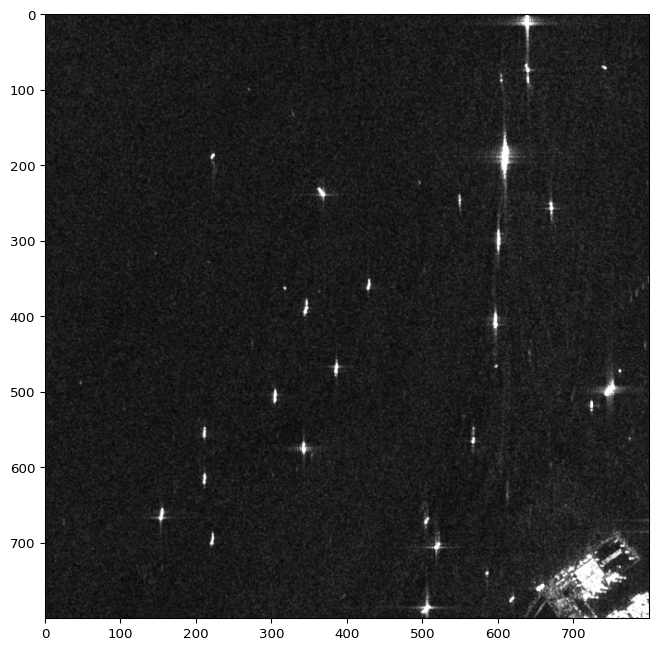

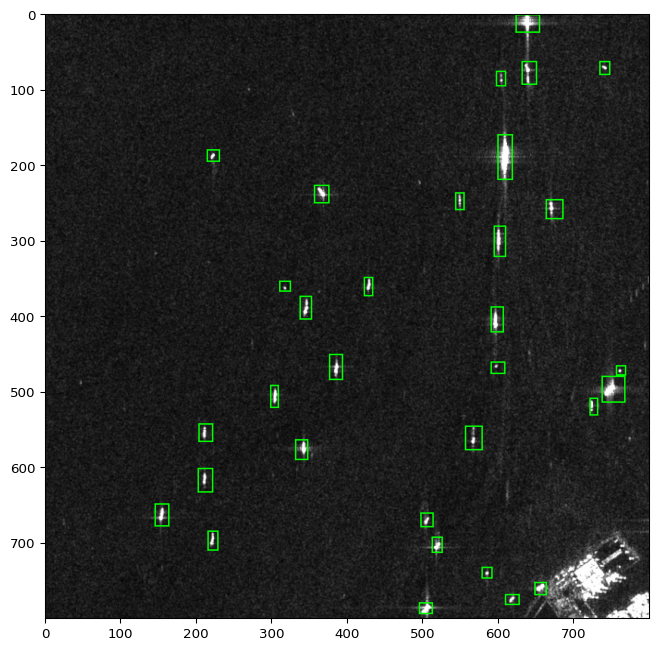

In [ ]:
# get bounding boxes coordinates from grouped data frame and write into array
# Return a Numpy representation of the DataFrame.       
#bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).to_numpy() # the same as above
print(type(bb_array))
print(bb_array.shape)

image = imageio.imread(jpg_path + image_name + '.jpg')
print(type(image))
print(image.shape)

# pass the array of bounding boxes coordinates to the imgaug library
bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
print(type(bbs))

# display the image and draw bounding boxes
ia.imshow(image)
ia.imshow(bbs.draw_on_image(image, size=2))

# Registering with Detectron2

## Conversion to Detectron2's Standard Dataset Dicts


According to https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#standard-dataset-dicts:

The original dataset is loaded into list[dict].

Each dict contains information about one image with the following fields:
  - file_name: the full path to the image file.
  - height, width: integer. The shape of the image.
  - image_id (str or int): a unique id that identifies this image. Required by many evaluators to identify the images, but a dataset may use it for different purposes.
  - annotations (list[dict]): Required by instance detection/segmentation or keypoint detection tasks. 
  Each dict corresponds to annotations of one instance in this image, and may contain the following keys:
      - bbox (list[float], required): list of 4 numbers representing the bounding box of the instance.
      - bbox_mode (int, required): the format of bbox. It must be a member of structures.BoxMode. Currently supports: BoxMode.XYXY_ABS, BoxMode.XYWH_ABS.
      - category_id (int, required): an integer in the range [0, num_categories-1] representing the category label. The value num_categories is reserved to represent the “background” category, if applicable.

In [ ]:
# Function that converts annotations to Detectron's format
# and then saves a pickle output to path
def standardize(path, annotations, df, grouped):
  anns_id = [i.split('.')[0] for i in annotations]
  anns_df = pd.DataFrame(anns_id, columns=['file'])

  # Attach correct image file path
  anns_df = df.merge(df, 
                     on = 'file',  
                     how = 'inner')
  
  # Give default values
  std = {i: {
        "file_name": df.loc[df['file'] == i]['type'].values[0] + i +'.jpg',
        "height": 800, # All images of the same dimension
        "width": 800, # All images of the same dimension
        "image_id": i,
        "annotations": []
        } for i in df['file'].values
      }
  
  # Overwrite files with correct annotations
  keys = grouped.groups.keys()
  for i in keys:
    if i.split('.')[0] in std:
      j = grouped.get_group(i)
      temp = []
      for index, row in j.iterrows():
        ann_temp = {
            'bbox': [
                      row['xmin'],
                      row['ymin'],
                      row['xmax'],
                      row['ymax']
                    ],
            'bbox_mode': BoxMode.XYXY_ABS,
            'category_id': 0
            }
        temp.append(ann_temp)
      std[i.split('.')[0]]['annotations'] = temp
  
  # Cache
  f = open(path + "standardDict.pkl", "wb")  # the "wb" mode opens the file in binary format for writing
  pickle.dump(list(std.values()), f)
  f.close()
  
  return std

In [ ]:
# Add path to datasets
test['type'] = dest + 'test/'
train['type'] = dest + 'train/'
test_offshore['type'] = dest + 'test_offshore/'
test_inshore['type'] = dest + 'test_inshore/'

In [ ]:
test.head()

,file,type
0,11_10_1,/content/drive/MyDrive/SSDD/datasets/test/
1,11_10_10,/content/drive/MyDrive/SSDD/datasets/test/
2,11_10_11,/content/drive/MyDrive/SSDD/datasets/test/
3,11_10_12,/content/drive/MyDrive/SSDD/datasets/test/
4,11_10_13,/content/drive/MyDrive/SSDD/datasets/test/


In [ ]:
# All xml annotations
# Return a list containing the names of the entries in the directory
anns = os.listdir(xml_path)

print(type(anns))
print(len(anns))
print(anns[0])

<class 'list'>
9000
14_16_4.xml


In [ ]:
# Make standardized annotations
test_std = standardize(dest + 'test/', anns, test, grouped)
train_std = standardize(dest + 'train/', anns, train, grouped)
test_o_std = standardize(dest + 'test_offshore/', anns, test_offshore, grouped)
test_i_std = standardize(dest + 'test_inshore/', anns, test_inshore, grouped)

In [ ]:
# Verification
assert(len(test_std) + len(train_std) == len(anns))
assert((len(test_std) == len(test_o_std) + len(test_i_std)))
train_std['01_18_12']

{'annotations': [{'bbox': [624, 1, 654, 23],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [598, 76, 609, 94],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [632, 63, 650, 92],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [735, 63, 747, 79],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [215, 180, 230, 194],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [357, 227, 375, 249],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [544, 237, 554, 258],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [600, 160, 618, 218],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [664, 246, 685, 270],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [311, 354, 324, 366],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [338, 374, 352, 403],
   'bbox_mode': <BoxM

In [ ]:
# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/MyDrive/SSDD/datasets/' + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

## Split Train into Train and Validation Sets

### Validation Set

In [ ]:
train = get_dict('train')

In [ ]:
print(type(train))
print(len(train))
print(type(train[0]))
print(train[1000])

<class 'list'>
6000
<class 'dict'>
{'file_name': '/content/drive/MyDrive/SSDD/datasets/train/02_3_19.jpg', 'height': 800, 'width': 800, 'image_id': '02_3_19', 'annotations': [{'bbox': [204, 361, 240, 393], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]}


In [ ]:
k = int(len(train) * 0.15)
print(k)

900


In [ ]:
import random
random.seed(1)
total_idx = list(range(len(train)))
val_idx = random.sample(total_idx, k = k)

In [ ]:
train_idx = set(total_idx) - set(val_idx)

In [ ]:
len(train_idx)

5100

In [ ]:
assert [i for i in val_idx if i in train_idx] == []

In [ ]:
train_with_val = [train[i] for i in train_idx]
validation = [train[i] for i in val_idx]

In [ ]:
print(len(train_with_val))
print(len(validation))

5100
900


In [ ]:
print(type(train_with_val))
print(type(validation))

<class 'list'>
<class 'list'>


In [ ]:
f = open(dest + 'train/train_w_val/' + "standardDict.pkl", "wb")
#pickle.dump(list(train_with_val), f)
pickle.dump(train_with_val, f)
f.close()

f = open(dest + 'train/validation/' + "standardDict.pkl", "wb")
#pickle.dump(list(validation), f)
pickle.dump(validation, f)
f.close()

### Toy Dataset

In [ ]:
toy_idx = random.sample(train_idx, k = 100)

print(type(train_idx))
print(type(toy_idx))
print(len(toy_idx))

<class 'set'>
<class 'list'>
100


In [ ]:
toy = [train[i] for i in toy_idx]

In [ ]:
print(len(toy))
print(type(toy))

100
<class 'list'>


In [ ]:
f = open(dest + 'train/toy/' + "standardDict.pkl", "wb")
#pickle.dump(list(toy), f)
pickle.dump(toy, f)
f.close()

## Verify Data Loader Functionality

### Imports
*Standard from Detectron2's docs*

*Restart after executing this cell*

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
exit(0)

     |████████████████████████████████| 276kB 11.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=08a91abd01583883be53695b80045416f935e0937e64c65dcb8397bc97fee182
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


1.8.0+cu101 False
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



*Restart after executing this cell*

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 682kB/s 
     |████████████████████████████████| 2.2MB 14.7MB/s 
     |████████████████████████████████| 51kB 4.0MB/s 
  Created wheel for iopath: filename=iopath-0.1.6-cp37-none-any.whl size=18269 sha256=60663740b77a8444becb6162d94de4c06ab4ea99ba6d7dd9b5415c2aa39975ba
  Stored in directory: /root/.cache/pip/wheels/ff/87/55/7513122394822977f993e1798bfebb46730d6183df8db7b283
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=807c31518355e5fbac7156bcda956b1f28be20d565b5a34b4f7e48f1e312ecc3
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built iopath fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling 

### Verification

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
datasets = '/content/drive/MyDrive/SSDD/datasets/'

In [ ]:
# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/MyDrive/SSDD/datasets/' + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

In [ ]:
from detectron2.structures import BoxMode

pre = 'ssdd_'

# Register
for d in ["train", "test", "test_offshore", "test_inshore", "train/train_w_val", "train/validation", "train/toy"]:
    DatasetCatalog.register(pre + d, lambda d=d: get_dict(d))
    MetadataCatalog.get(pre + d).set(thing_classes=["ship"])

In [ ]:
# Instances of metadata
train_metadata = MetadataCatalog.get(pre + 'train')

Metadata(name='ssdd_train', thing_classes=['ship'])

In [ ]:
print(type(train_metadata))
print(train_metadata)

<class 'detectron2.data.catalog.Metadata'>
Metadata(name='ssdd_train', thing_classes=['ship'])


In [ ]:
dataset_dicts = get_dict("train/train_w_val")  # list[dict]

print(dataset_dicts[0].keys())
print(dataset_dicts[0]['file_name'])

# Filter out pics w/o annotations
dataset_dicts_anns = []
for i in dataset_dicts:
  if i['annotations'] != []:
    dataset_dicts_anns.append(i)

dict_keys(['file_name', 'height', 'width', 'image_id', 'annotations'])
/content/drive/MyDrive/SSDD/datasets/train/01_10_1.jpg


{'file_name': '/content/drive/MyDrive/SSDD/datasets/train/09_12_10.jpg', 'height': 800, 'width': 800, 'image_id': '09_12_10', 'annotations': [{'bbox': [663, 363, 676, 385], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [302, 587, 322, 601], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]}


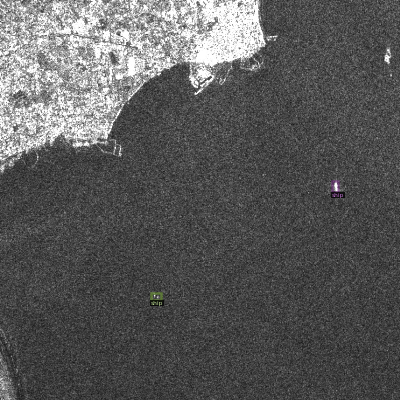

In [ ]:
#random.seed(1)
for d in random.sample(dataset_dicts_anns, 1):
    print(d)
    img = cv2.imread(d["file_name"])  # loads an image from a file and returns a numpy array of shape (H, W, C) <class 'numpy.ndarray'>
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)  # <class 'detectron2.utils.visualizer.Visualizer'>
    out = visualizer.draw_dataset_dict(d)  # <class 'detectron2.utils.visualizer.VisImage'>
    cv2_imshow(out.get_image()[:, :, ::-1])  # get_image() returns a numpy array of shape (H, W, C) <class 'numpy.ndarray'>